In [ ]:
%pip install gym

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import threading
import multiprocessing
import matplotlib.pyplot as plt
import queue

env_name = "Blackjack-v1"
env = gym.make(env_name)

In [2]:
class ActorCriticModel(tf.keras.Model):
    def __init__(self, action_size):
        super(ActorCriticModel, self).__init__()
        self.common = layers.Dense(128, activation='relu')
        self.actor = layers.Dense(action_size, activation='softmax')
        self.critic = layers.Dense(1)

    def call(self, inputs):
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

def build_model(action_size):
    model = ActorCriticModel(action_size)
    return model


In [3]:
class A3CWorker(threading.Thread):
    def __init__(self, env_name, global_model, optimizer, result_queue, idx, max_episodes, gamma=0.99):
        super(A3CWorker, self).__init__()
        self.result_queue = result_queue
        self.global_model = global_model
        self.optimizer = optimizer
        self.idx = idx
        self.gamma = gamma
        self.env = gym.make(env_name)
        self.local_model = build_model(self.env.action_space.n)
        self.episodes = 0
        self.max_episodes = max_episodes

    def run(self):
        total_step = 1
        while self.episodes < self.max_episodes:
            current_state = self.env.reset()
            done = False
            score = 0
            while not done:
                # Get the action probabilities from the local model
                logits, _ = self.local_model(tf.convert_to_tensor(np.expand_dims(current_state, axis=0), dtype=tf.float32))
                # Select an action based on the probabilities
                action = np.random.choice(self.env.action_space.n, p=logits.numpy().ravel())
                new_state, reward, done, _ = self.env.step(action)
                score += reward
                self.episodes += 1

                # Update model parameters
                with tf.GradientTape() as tape:
                  # Get the value estimates for the current and new states
                    logits, values = self.local_model(tf.convert_to_tensor(np.expand_dims(current_state, axis=0), dtype=tf.float32))
                    _, next_value = self.local_model(tf.convert_to_tensor(np.expand_dims(new_state, axis=0), dtype=tf.float32))
                    # Calculate the target value
                    target = reward + self.gamma * next_value * (1 - done)
                    advantage = target - values
                    actor_loss = -tf.math.log(logits[0, action]) * advantage
                    critic_loss = advantage ** 2
                    total_loss = actor_loss + critic_loss

                # Compute gradients
                grads = tape.gradient(total_loss, self.local_model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.global_model.trainable_weights))
                current_state = new_state
                total_step += 1

            self.result_queue.put(score)
            print(f"Worker {self.idx} | Episode: {self.episodes} | Score: {score}")


In [ ]:
def train_a3c(env_name, num_workers=multiprocessing.cpu_count(), max_episodes=1000):
    env = gym.make(env_name)
    state_size = len(env.observation_space.sample())
    action_size = env.action_space.n

    global_model = build_model(action_size)
    global_model(tf.convert_to_tensor(np.random.random((1, state_size)), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    result_queue = queue.Queue()
    #intialize workers
    workers = [A3CWorker(env_name, global_model, optimizer, result_queue, idx, max_episodes) for idx in range(num_workers)]

    for worker in workers:
        worker.start()

    scores = []
    for _ in range(max_episodes):  # Collect results
        scores.append(result_queue.get())

    # Join threads
    for worker in workers:
        worker.join()

    return scores, global_model

scores, model = train_a3c(env_name)

In [ ]:
def train_a3c(env_name, num_workers=multiprocessing.cpu_count(), max_episodes=1000):
    env = gym.make(env_name)
    state_size = len(env.observation_space.sample())
    action_size = env.action_space.n

    global_model = build_model(action_size)
    global_model(tf.convert_to_tensor(np.random.random((1, state_size)), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    result_queue = queue.Queue()
    #intialize workers
    workers = [A3CWorker(env_name, global_model, optimizer, result_queue, idx, max_episodes) for idx in range(num_workers)]

    for worker in workers:
        worker.start()

    scores = []
    for _ in range(max_episodes):  # Collect results
        scores.append(result_queue.get())

    # Join threads
    for worker in workers:
        worker.join()

    return scores, global_model

scores, model = train_a3c(env_name)

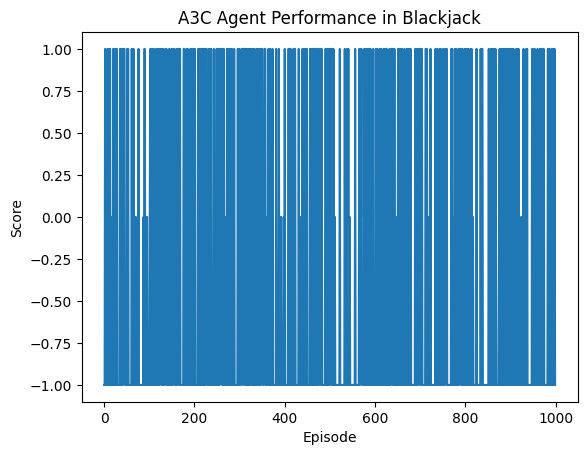

In [ ]:
def plot_results(scores):
    plt.plot(scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('A3C Agent Performance in Blackjack')
    plt.show()

plot_results(scores)

In [6]:
env = gym.make(env_name)
games = 10
wins = 0
losses = 0
draws = 0
verbose = True

for episode in range(games):
    current_state = env.reset()
    done = False
    score = 0
    player_hand = []
    dealer_hand = []

    # Get the initial player and dealer cards
    player_hand.append(current_state[0])  # Player's first card
    dealer_visible_card = current_state[1]  # Dealer's visible card (1-10 where 1 is ace)
    dealer_hand.append(dealer_visible_card)

    while not done:
        logits, _ = model(tf.convert_to_tensor(np.expand_dims(current_state, axis=0), dtype=tf.float32))
        action = np.argmax(logits.numpy())
        new_state, reward, done, _ = env.step(action)
        score += reward
        current_state = new_state
    # Update the player's hand
        if action == 1:  # Hit
            player_hand.append(current_state[0])

    if (verbose):
      # Print the result of the game
      print("Player's hand:", [count for count in player_hand])
      print("Deale visible hand:",dealer_visible_card)

    if score > 0:
        print("Win! :) ", score, "\n")
        wins += 1
    elif score == 0:
        print("Draw! :| ", score, "\n")
        draws += 1
    else:
        print("Loss! :( ", score, "\n")
        losses += 1

print("Win percentage: ", (wins/games)*100, "%\n")
print("Draw percentage: ", (draws/games)*100, "%\n")
print("Losing percentage: ", (losses/games)*100, "%\n")

Player's hand: [12]
Deale visible hand: 10
Loss! :(  -1.0 

Player's hand: [12]
Deale visible hand: 1
Loss! :(  -1.0 

Player's hand: [12]
Deale visible hand: 4
Loss! :(  -1.0 

Player's hand: [12]
Deale visible hand: 8
Loss! :(  -1.0 

Player's hand: [13]
Deale visible hand: 5
Loss! :(  -1.0 

Player's hand: [21]
Deale visible hand: 2
Win! :)  1.0 

Player's hand: [17]
Deale visible hand: 7
Loss! :(  -1.0 

Player's hand: [17]
Deale visible hand: 2
Loss! :(  -1.0 

Player's hand: [15]
Deale visible hand: 6
Win! :)  1.0 

Player's hand: [13]
Deale visible hand: 8
Win! :)  1.0 

Win percentage:  30.0 %

Draw percentage:  0.0 %

Losing percentage:  70.0 %

